In [4]:
#John's
import numpy as np
import tensorflow as tf
import os
import time
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from datetime import datetime
import statistics as stat
import ROOT
now = datetime.utcnow().strftime("%y%m%d%H%M%S")

2023-08-11 02:01:56.575352: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.3-6fa5c/x86_64-centos7-gcc11-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.3-c1d8e/x86_64-centos7-gcc11-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/jaxlib/mlir/_mlir_libs:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/onnxruntime/capi/:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow/contrib

Welcome to JupyROOT 6.28/00


In [5]:
#Mine
import uproot
import pandas as pd
# import numpy as np
import boost_histogram as bh
# import matplotlib.pyplot as plt
import pickle
import gc
import atlasplots as ap
%matplotlib inline

In [7]:
version = 'full_v02'
conv = 'unconv'
evenoddmodel = 'even'
evenoddtrain = 'odd'

In [8]:
nameofmodel = 'fclass_'+version+conv+'_1mil_'+evenoddmodel

In [9]:
with open('TRAININGTEST/models/'+nameofmodel+'.json') as file:
    f_even = tf.keras.models.model_from_json(file.read())

2023-08-11 02:02:45.983964: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.3-6fa5c/x86_64-centos7-gcc11-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.3-c1d8e/x86_64-centos7-gcc11-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/jaxlib/mlir/_mlir_libs:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/onnxruntime/capi/:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow/contrib/tensor_fo

In [10]:
f_even.load_weights('TRAININGTEST/models/'+nameofmodel+'.h5')

In [11]:
df_eca = pickle.load(open('TRAININGTEST/data/full_v02_ec2mil_a.pickle', 'rb'))
df_ecz = pickle.load(open('TRAININGTEST/data/full_v02_ec2mil_z.pickle', 'rb'))
df_eua = pickle.load(open('TRAININGTEST/data/full_v01_eu2mil_a.pickle', 'rb'))
df_euz = pickle.load(open('TRAININGTEST/data/full_v01_eu2mil_z.pickle', 'rb'))
df_oca = pickle.load(open('TRAININGTEST/data/full_v02_oc2mil_a.pickle', 'rb'))
df_ocz = pickle.load(open('TRAININGTEST/data/full_v02_oc2mil_z.pickle', 'rb'))
df_oua = pickle.load(open('TRAININGTEST/data/full_v01_ou2mil_a.pickle', 'rb'))
df_ouz = pickle.load(open('TRAININGTEST/data/full_v01_ou2mil_z.pickle', 'rb'))

In [12]:
df_evenc = pd.concat([df_eua,df_euz])
df_oddc = pd.concat([df_oua,df_ouz])
del df_eca
del df_ecz
del df_oca
del df_ocz
gc.collect()

12

In [13]:
features_stand = ['HadLeakage_stand', 'y_Reta_stand', 'y_Rphi_stand', 'y_weta2_stand',
                   'y_wtots1_stand', 'y_weta1_stand', 'y_fracs1_stand', 'y_deltae_stand',
                   'y_Eratio_stand', 'y_f1_stand']
features = ['HadLeakage', 'y_Reta', 'y_weta2', 'y_Rphi', 'y_wtots1', 
            'y_weta1', 'y_fracs1', 'y_deltae', 'y_Eratio', 'y_f1']

In [14]:
# FOR NOW just doing **unconv.**  variables
featlist = features_stand   # either features or features_stand 
weightstr = 'finalWeight'   #either 'finalWeight' for E_T and eta weighting or 'goodWeight' for not


# for unconverted. (##add in option to change later)
features_even = np.array(df_evenc[featlist])
labels_even   = np.array(df_evenc['y_isTruthMatchedPhoton'])
weights_even  = np.array(df_evenc[weightstr])
features_odd = np.array(df_oddc[featlist])
labels_odd   = np.array(df_oddc['y_isTruthMatchedPhoton'])
weights_odd  = np.array(df_oddc[weightstr])

# train_features_odd = np.array(df_oddc[featlist])
# train_labels_odd   = np.array(df_oddc['y_isTruthMatchedPhoton'])
# train_weights_odd  = np.array(df_oddc[weightstr])
# test_features_odd = np.array(df_evenc[featlist])
# test_labels_odd   = np.array(df_evenc['y_isTruthMatchedPhoton'])
# test_weights_odd  = np.array(df_evenc[weightstr])

In [15]:
y_pred = f_even.predict(features_odd).ravel()
y_pred

array([0.0087809 , 0.9283887 , 0.87638974, ..., 0.92546725, 0.90596545,
       0.9386684 ], dtype=float32)

In [16]:
sig = np.array(df_oddc.y_isTruthMatchedPhoton)
bkg = np.array(~df_oddc.y_isTruthMatchedPhoton)

Text(0.5, 1.0, 'Odd Converted Real, First & Last 2mil Events')

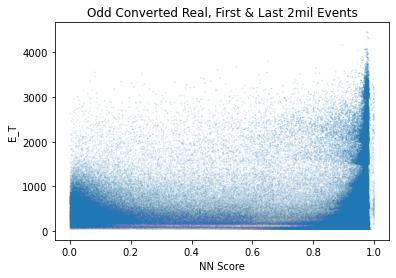

In [12]:
plt.scatter(y_pred[sig],df_oddc.y_pt.ravel()[sig],alpha=df_oddc.y_pt.ravel()[sig]/10000,s=0.1)
plt.xlabel('NN Score');plt.ylabel('E_T')
plt.title('Odd Converted Real, First & Last 2mil Events')

Text(0.5, 1.0, 'Odd Converted Fake, First & Last 2mil Events')

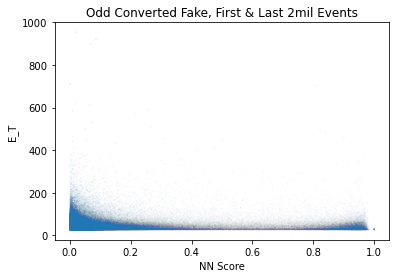

In [13]:
plt.scatter(y_pred[bkg],df_oddc.y_pt.ravel()[bkg],alpha=df_oddc.y_pt.ravel()[bkg]/4000,s=0.1)
plt.xlabel('NN Score');plt.ylabel('E_T')
plt.title('Odd Converted Fake, First & Last 2mil Events')

Text(0.5, 1.0, 'Odd Converted Real, First & Last 2mil Events')

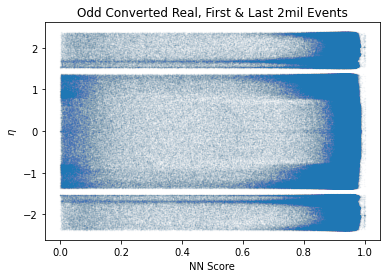

In [14]:
plt.scatter(y_pred[sig],df_oddc.y_eta.ravel()[sig],alpha=0.05,s=0.1)
plt.xlabel('NN Score');plt.ylabel(r'$\eta$')
plt.title('Odd Converted Real, First & Last 2mil Events')

Text(0.5, 1.0, 'Odd Converted Real, First & Last 2mil Events')

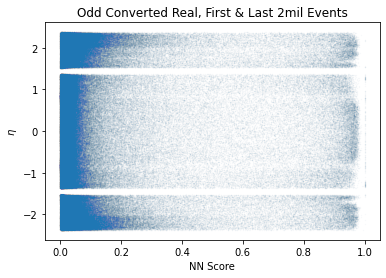

In [15]:
plt.scatter(y_pred[bkg],df_oddc.y_eta.ravel()[bkg],alpha=0.05,s=0.1)
plt.xlabel('NN Score');plt.ylabel(r'$\eta$')
plt.title('Odd Converted Real, First & Last 2mil Events')

In [16]:
#2D histograms with event weights:
#(to add weighting to heatmaps)

def plothist2d(h):
    return plt.pcolormesh(*h.axes.edges.T, h.values().T, norm=colors.LogNorm(vmin=0.001, vmax=10))

# where h is a:
# h = bh.Histogram(bh.axis.Variable(binning_lph_pT),bh.axis.Variable(binning_lph_pT),storage=bh.storage.Weight())
# h.fill(matched_df[matched_df.channel==2].lph_pT, matched_df[matched_df.channel==2].truth_lph_pT, weight=matched_df[matched_df.channel==2]['fullEventWeight'])

In [17]:
x = y_pred
y = df_oddc.y_eta.ravel()

In [18]:
# wcounts, xedges, yedges = np.histogram2d(x, y, weights=df_oddc.finalWeight.ravel())


In [19]:
# extent = xedges[0], xedges[-1], yedges[0], yedges[-1]
# plt.imshow(wcounts, extent=extent, alpha=0.5)

In [20]:
# plt.hexbin?

In [28]:
# ###try heatmaps (i.e. 2d histograms)


# from matplotlib import pyplot as PLT
from matplotlib import cm as CM
from matplotlib import mlab as ML
# import numpy as NP

import matplotlib.colors as colors

# # n = 1e5
# # x = y = NP.linspace(-5, 5, 100)
# # X, Y = NP.meshgrid(x, y)
# # Z1 = ML.bivariate_normal(X, Y, 2, 2, 0, 0)
# # Z2 = ML.bivariate_normal(X, Y, 4, 1, 1, 1)
# # ZD = Z2 - Z1
# # x = X.ravel()
# # y = Y.ravel()
# # z = ZD.ravel()
# gridsize=200
# plt.subplot(111)

# # # if 'bins=None', then color of each hexagon corresponds directly to its count
# # # 'C' is optional--it maps values to x-y coordinates; if 'C' is None (default) then 
# # # the result is a pure 2D histogram 
# x = y_pred
# y = df_oddc.y_eta.ravel()

# plt.hexbin(x, y, gridsize=gridsize, cmap=CM.jet, bins=None, norm=colors.LogNorm())
# plt.axis([x.min(), x.max(), y.min(), y.max()])

# cb = plt.colorbar()
# cb.set_label('count')  #make this log(count)

# plt.xlabel('NN Score')
# plt.ylabel(r'$\eta$')
# plt.title('Odd Converted, First & Last 2mil Events')

# plt.show() 

In [29]:
# gridsize=200
# plt.subplot(111)

# # # if 'bins=None', then color of each hexagon corresponds directly to its count
# # # 'C' is optional--it maps values to x-y coordinates; if 'C' is None (default) then 
# # # the result is a pure 2D histogram 
# x = y_pred
y2 = df_oddc.y_pt.ravel()

# plt.hexbin(x, y2, gridsize=gridsize, cmap=CM.jet, bins=None, norm=colors.LogNorm())
# plt.axis([x.min(), x.max(), y2.min(), y2.max()])

# cb = plt.colorbar()
# cb.set_label('count')

# plt.xlabel('NN Score')
# plt.ylabel(r'$E_T$ (GeV)')
# plt.title('Odd Converted, First & Last 2mil Events')

# plt.show() 

In [30]:
# do it weighted, and separate signal and bkg (real and fakes)

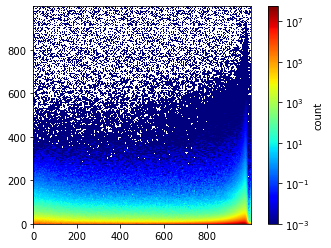

In [31]:
#or


# import numpy as np
# import numpy.random
# import matplotlib.pyplot as plt

# # Generate some test data
# x = np.random.randn(8873)
# y = np.random.randn(8873)

heatmap, xedges, yedges = np.histogram2d(x[sig], y2[sig], bins=1000, weights=df_oddc.finalWeight.ravel()[sig])
# extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, origin='lower',cmap=CM.jet, norm=colors.LogNorm(vmin=0.001))

cb = plt.colorbar()
cb.set_label('count')  #make this log(count)

plt.show()



In [32]:
# plt.pcolormesh?

In [33]:
# plt.imshow?

In [ ]:
from scipy.stats import pearsonr


In [18]:
xsig = y_pred[sig]
xbkg = y_pred[bkg]

In [ ]:
### change finalWeight to goodWeight

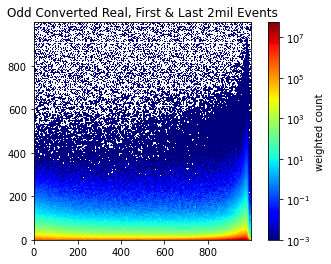

In [35]:
##E_T  sig
yETsig = df_oddc.y_pt.ravel()[sig]

heatmap, xedges, yedges = np.histogram2d(xsig, yETsig, bins=1000, weights=df_oddc.finalWeight.ravel()[sig])
# extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, origin='lower',cmap=CM.jet, norm=colors.LogNorm(vmin=0.001))

cb = plt.colorbar()
cb.set_label('weighted count') 

plt.title('Odd Converted Real, First & Last 2mil Events')
plt.show()



In [23]:
from scipy.stats import pearsonr
# pearsonr?

def m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)

def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

corr(df_oddc.y_pt[bkg], xbkg, df_oddc.finalWeight[bkg])

0.07188438643778246

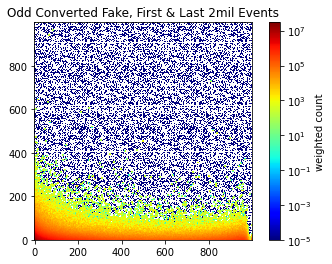

In [36]:
##E_T bkg
yETbkg = df_oddc.y_pt.ravel()[bkg]

heatmap, xedges, yedges = np.histogram2d(xbkg, yETbkg, bins=1000, weights=df_oddc.finalWeight.ravel()[bkg])
# extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, origin='lower',cmap=CM.jet, norm=colors.LogNorm(vmin=0.00001))

cb = plt.colorbar()
cb.set_label('weighted count') 

plt.title('Odd Converted Fake, First & Last 2mil Events')
plt.show()



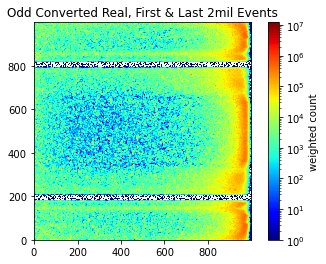

In [37]:
##ETA sig
yETAsig = df_oddc.y_eta.ravel()[sig]

heatmap, xedges, yedges = np.histogram2d(xsig, yETAsig, bins=1000, weights=df_oddc.finalWeight.ravel()[sig])
# extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, origin='lower',cmap=CM.jet, norm=colors.LogNorm(vmin=1))

cb = plt.colorbar()
cb.set_label('weighted count') 

plt.title('Odd Converted Real, First & Last 2mil Events')
plt.show()



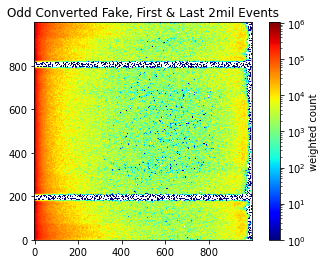

In [39]:
##ETA bkg
yETAbkg = df_oddc.y_eta.ravel()[bkg]

heatmap, xedges, yedges = np.histogram2d(xbkg, yETAbkg, bins=1000, weights=df_oddc.finalWeight.ravel()[bkg])
# extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, origin='lower',cmap=CM.jet, norm=colors.LogNorm(vmin=1))

cb = plt.colorbar()
cb.set_label('weighted count') 

plt.title('Odd Converted Fake, First & Last 2mil Events')
plt.show()



In [41]:
### creating bar plots of avg of variables in each bin of NN score
NNbinedges=np.linspace(0,1,21)
NNbinedges

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

Text(0.5, 1.0, 'Average y_fracs1 in NN Score bins of 0.05\nOdd Converted')

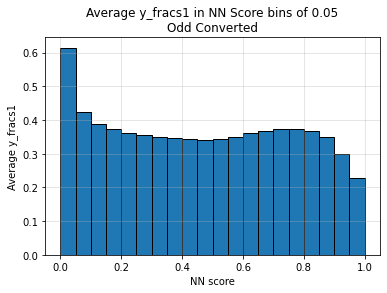

In [65]:
variable = 'y_fracs1'

binvals = []
for i in range(len(NNbinedges)-1):
    boolmask = (y_pred >= NNbinedges[i]) & (y_pred <= NNbinedges[i+1])
    variablelist = np.array(df_oddc[variable][boolmask])
    average = np.mean(variablelist)
    binvals.append(average)
    
width = np.diff(NNbinedges)[0]
leftedge = NNbinedges[:-1]
plt.bar(leftedge,binvals,width,align='edge',edgecolor='k')
plt.grid(alpha=0.4)
plt.xlabel('NN score');plt.ylabel('Average '+variable)
plt.title('Average '+variable+' in NN Score bins of 0.05\n'+'Odd Converted')

In [13]:
def averageplot(df,y_pred,variable,variablelabel=False,dflabel='',width=0.05,minn=0,figname=False):
    
    if variablelabel == False:
        variablelabel = variable
    if minn > 0:
        minn = 0
    
    NNbinedges = np.arange(0,1+width,width)
    binvals = []
    
    for i in range(len(NNbinedges)-1):
        boolmask = (y_pred >= NNbinedges[i]) & (y_pred < NNbinedges[i+1]) & (df[variable] >= 5*minn)
        variablelist = np.array(df[variable][boolmask])
        weightlist = np.array(df['finalWeight'][boolmask])
        average = np.average(variablelist,weights=weightlist)
        binvals.append(average)

    leftedge = NNbinedges[:-1]
    plt.bar(leftedge,binvals,width,align='edge',edgecolor='k')
    plt.grid(alpha=0.4)
    plt.xlabel('NN score');plt.ylabel(r'Weighted Average '+variablelabel)
    plt.title(r'Average '+variablelabel+' in NN Score bins of 0.05\n'+dflabel)
    if bool(figname)==True:
        plt.savefig(figname+'.png',dpi=360,format='png')
    plt.show()
    plt.close()

In [14]:
branchlist = ['HadLeakage',
  'y_Reta',
  'y_Rphi',
  'y_weta2',
  'y_wtots1',
  'y_weta1',
  'y_fracs1',
  'y_deltae',
  'y_Eratio',
  'y_f1']

labellist = ['HadLeakage',
  r'$R_{\eta}$',
  r'$R_{\phi}$',
  r'$w_{\eta_2}$',
  r'$w_{s \hspace{.4} tot}$',
  r'$w_{s \hspace{.4}3}$',
  r'$f_{side}$',
  r'$\Delta E_s$',
  r'$E_{ratio}$',
  r'$f_1$']

minmaxlist =[(-0.5, 5),
  (0.1, 1.25),
  (0.1, 1.25),
  (0.002, 0.023),
  (-0.2, 15),
  (0, 0.9),
  (-0.2, 2),
  (-200, 4000),
  (-0.3, 1.1),
  (-0.05, 0.9)]

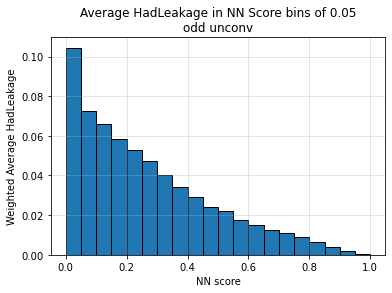

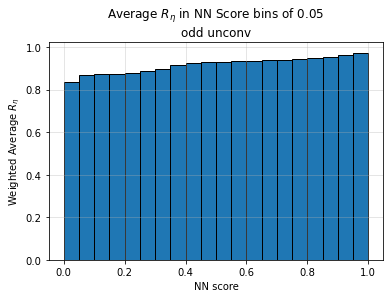

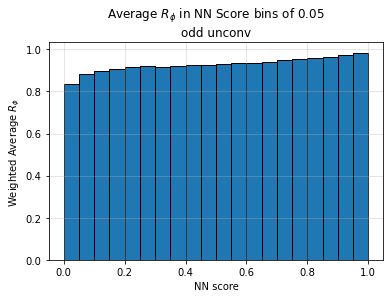

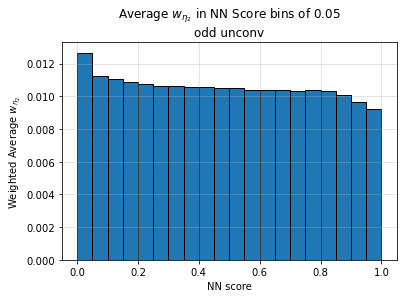

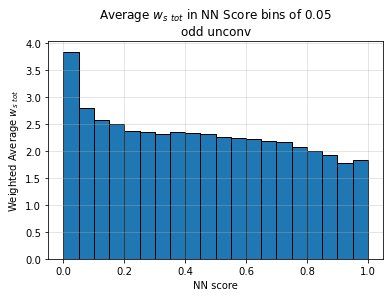

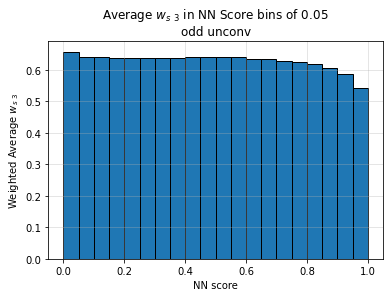

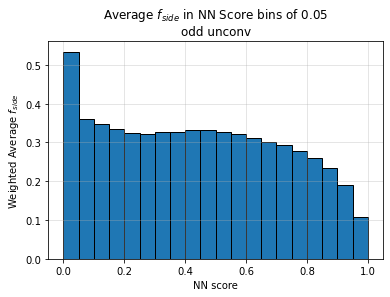

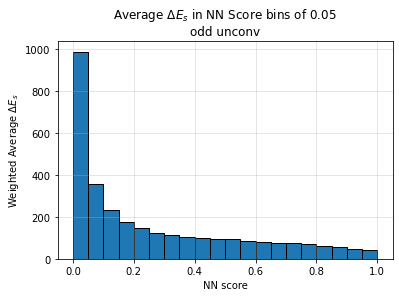

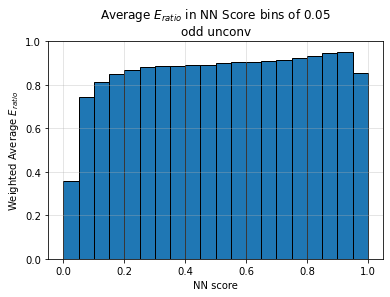

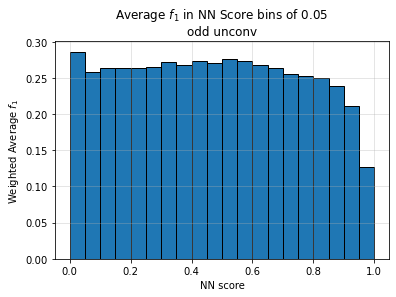

In [30]:
for variable,label,minmax in zip(branchlist,labellist,minmaxlist):
    averageplot(df_oddc,y_pred,variable,variablelabel=label,dflabel=evenoddtrain+' '+conv,minn=minmax[0],figname='plots/averagevars/'+version+'_1mil_'+conv[0]+evenoddtrain[0]+'_'+variable)

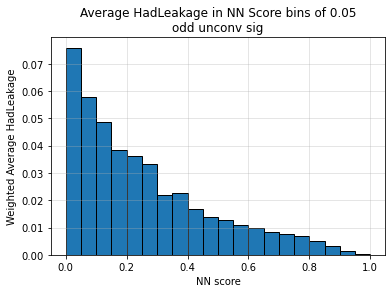

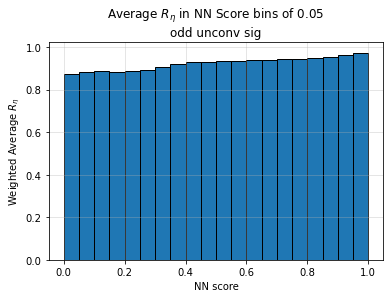

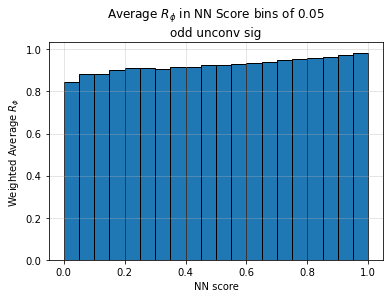

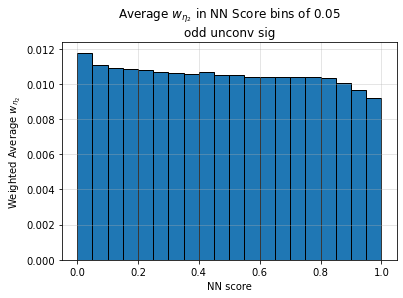

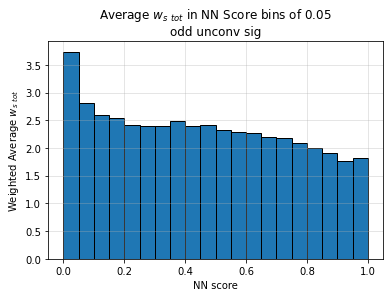

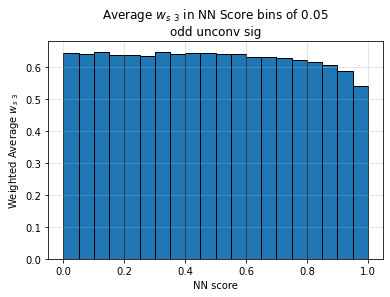

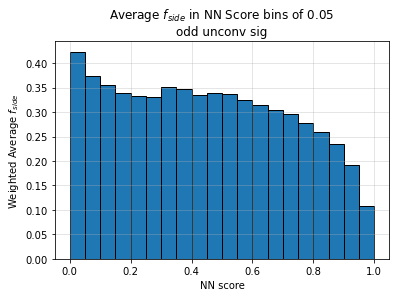

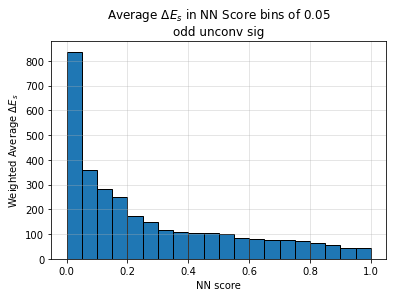

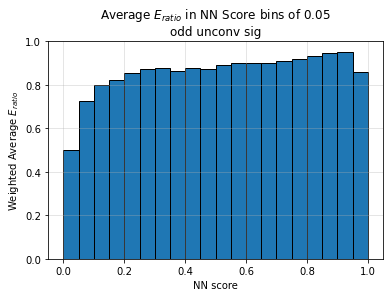

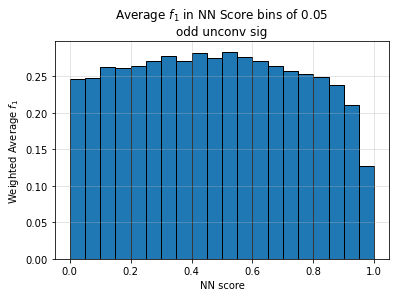

In [31]:
for variable,label,minmax in zip(branchlist,labellist,minmaxlist):
    averageplot(df_oddc[sig],y_pred[sig],variable,variablelabel=label,dflabel=evenoddtrain+' '+conv+' sig',minn=minmax[0],figname='plots/averagevars/'+version+'_1mil_'+conv[0]+evenoddtrain[0]+'_'+variable+'_sig')

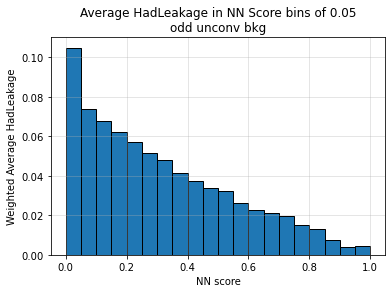

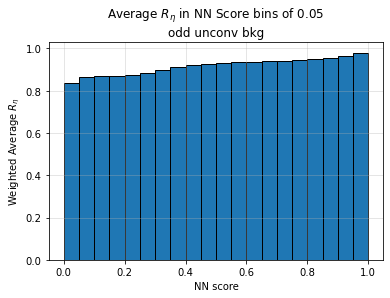

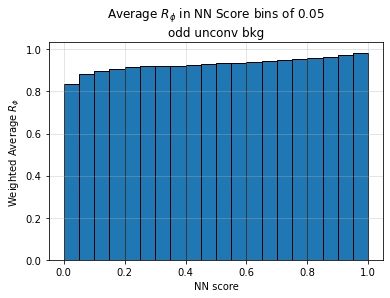

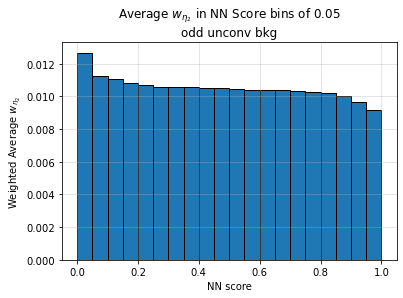

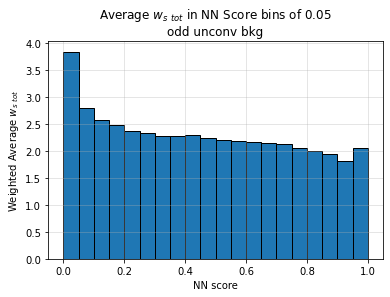

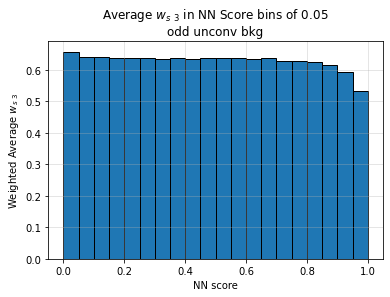

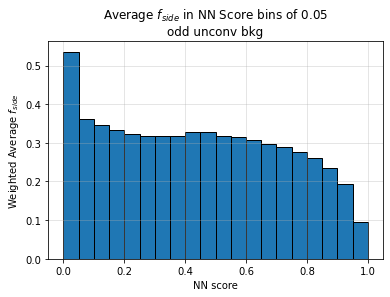

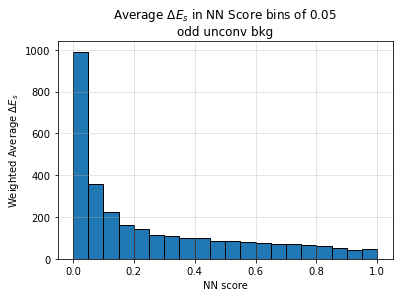

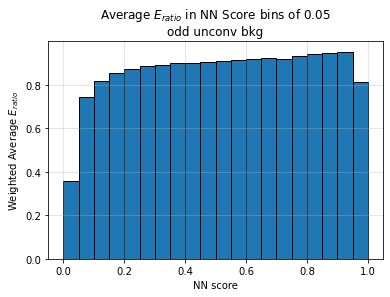

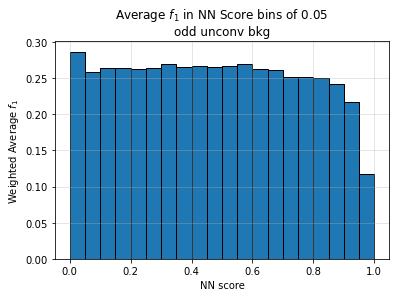

In [32]:
for variable,label,minmax in zip(branchlist,labellist,minmaxlist):
    averageplot(df_oddc[bkg],y_pred[bkg],variable,variablelabel=label,dflabel=evenoddtrain+' '+conv+' bkg',minn=minmax[0],figname='plots/averagevars/'+version+'_1mil_'+conv[0]+evenoddtrain[0]+'_'+variable+'_bkg')

In [94]:
np.mean?

In [129]:
zip?